This Notebook :
- preprocess the voting database
- merge it with the constituency data
- explore the link between the party in charge and the urban/rural share of the population (or transportation mode)
- find the specific votes that we will use 
- create the dataset that we will use for our regression

In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pathlib
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
path = 'C:/Users/veve1/OneDrive/Documents/ENSAE 3A/S2/Social Choice and Voting/Project/Social-Choice-and-Voting'
data_path = os.path.join(path,'Data')

In [4]:
df_scrutins = pd.read_csv(os.path.join(data_path,'database_scrutins_herve.csv'))
df_votants = pd.read_csv(os.path.join(data_path,'database_votants_herve.csv'))

In [5]:
df_scrutins.shape

(4417, 14)

### Get party position for each vote

In [6]:
df_votes = pd.read_csv(os.path.join(data_path,'database_votes_herve.csv'))

In [7]:
df_votes.drop('Unnamed: 0', axis= 1, inplace = True)
df_votes.dropna(axis = 0, inplace = True)
df_votes.head()

,idScrutin,idVotant,vote,organeRefGroupe,date_scrutin,code_type_vote,titre,demandeur,organe_ref,votants,pour,contre,non_votants,non_votants_volontaires,abstention,resultat
0,0,PA606171,Non-votant,PO730964,2020-10-07,SPO,l'article 24 bis du projet de loi portant dive...,"Président du groupe ""La République en Marche""",PO717460,57,56,0,2,0,1,adopté
1,0,PA721824,Non-votant,PO730964,2020-10-07,SPO,l'article 24 bis du projet de loi portant dive...,"Président du groupe ""La République en Marche""",PO717460,57,56,0,2,0,1,adopté
2,0,PA719952,Pour,PO730964,2020-10-07,SPO,l'article 24 bis du projet de loi portant dive...,"Président du groupe ""La République en Marche""",PO717460,57,56,0,2,0,1,adopté
3,0,PA607395,Pour,PO730964,2020-10-07,SPO,l'article 24 bis du projet de loi portant dive...,"Président du groupe ""La République en Marche""",PO717460,57,56,0,2,0,1,adopté
4,0,PA718710,Pour,PO730964,2020-10-07,SPO,l'article 24 bis du projet de loi portant dive...,"Président du groupe ""La République en Marche""",PO717460,57,56,0,2,0,1,adopté


In [8]:
df_votes['absention'] = df_votes['vote'].apply(lambda x : x== 'Non-votant')
df_votes = df_votes[df_votes['absention'] != True]

df_votes['vote'].unique()

array(['Pour', 'Contre'], dtype=object)

In [9]:
df_votes['vote_0_1'] = df_votes['vote'].apply(lambda x :x == 'Pour')

In [10]:
df_votes['NomGroupe'] = df_votes['organeRefGroupe']

dict_nom_groupe = {'PO774834':'MoDem', 'PO730970':'MoDem','PO730964':'LREM', 'PO771789':'Ecologie Démocratie Solidarité',
                  'PO771923':'Agir Ensemble', 'PO767217':'UDI_Agir', 'PO744425':'UDI_Agir', 'PO765636':'UDI_Independants',
                  'PO771889':'UDI_Independants', 'PO730952':'Les Constructifs', 'PO759900':'Libertés et Territoires',
                  'PO730934':'LR','PO723569':'Non inscrits', 'PO730946':'Nouvelle Gauche', 'PO758835':'Socialistes',
                  'PO730940':'Gauche Dem et Rep', 'PO730958':'France Insoumise'}

df_votes['NomGroupe'].replace(dict_nom_groupe, inplace= True)

# Some groups changed names over the Legislature but the group didn't change in itself
df_votes['NomGroupe'].replace({'Nouvelle Gauche' : 'Socialistes'}, inplace = True)

In [11]:
def position(df):
    df_groupe = df[['NomGroupe','vote_0_1']].groupby('NomGroupe').mean('vote_0_1')
    df_groupe['group_position'] = df_groupe['vote_0_1'].apply(lambda x : x >= 0.5)
    df_groupe.drop('vote_0_1', axis = 1, inplace = True)
    return(df_groupe)

In [12]:
df_positions_groupe = df_votes.groupby('idScrutin').apply(position)
df_positions_groupe.reset_index(inplace=True)

In [13]:
df_positions_groupe

,idScrutin,NomGroupe,group_position
0,0,Agir Ensemble,True
1,0,LR,True
2,0,LREM,True
3,0,Libertés et Territoires,True
4,0,MoDem,True
...,...,...,...
34722,4416,Libertés et Territoires,False
34723,4416,MoDem,False
34724,4416,Non inscrits,True
34725,4416,Socialistes,True


In [14]:
df_votes_short = df_votes[['idScrutin','idVotant','NomGroupe','vote_0_1']]
df_votes_final = df_votes_short.merge(df_positions_groupe, on = ['idScrutin','NomGroupe'], how = 'right')

In [15]:
df_votes_final

,idScrutin,idVotant,NomGroupe,vote_0_1,group_position
0,0,PA331567,Agir Ensemble,True,True
1,0,PA642868,Agir Ensemble,True,True
2,0,PA267780,Agir Ensemble,True,True
3,0,PA345722,LR,True,True
4,0,PA720210,LR,True,True
...,...,...,...,...,...
447054,4416,PA720230,UDI_Agir,True,True
447055,4416,PA719806,UDI_Agir,True,True
447056,4416,PA642868,UDI_Agir,True,True
447057,4416,PA267780,UDI_Agir,True,True


In [16]:
df_votes_final['NomGroupe'].unique()

array(['Agir Ensemble', 'LR', 'LREM', 'Libertés et Territoires', 'MoDem',
       'Non inscrits', 'Socialistes', 'UDI_Independants',
       'France Insoumise', 'Gauche Dem et Rep', 'UDI_Agir',
       'Les Constructifs', 'Ecologie Démocratie Solidarité'], dtype=object)

In [17]:
df_votes_final

,idScrutin,idVotant,NomGroupe,vote_0_1,group_position
0,0,PA331567,Agir Ensemble,True,True
1,0,PA642868,Agir Ensemble,True,True
2,0,PA267780,Agir Ensemble,True,True
3,0,PA345722,LR,True,True
4,0,PA720210,LR,True,True
...,...,...,...,...,...
447054,4416,PA720230,UDI_Agir,True,True
447055,4416,PA719806,UDI_Agir,True,True
447056,4416,PA642868,UDI_Agir,True,True
447057,4416,PA267780,UDI_Agir,True,True


In [18]:
df_votes_final.to_csv(os.path.join(data_path,'database_votes_finale.csv'))

# Final database

In [19]:
df_deputes = pd.read_csv(os.path.join(data_path,'députés.csv'))

In [20]:
df_deputes_matching = df_deputes[['identifiant','Département','Numéro de circonscription']]

df_deputes_matching['idVotant'] = 'PA' + df_deputes_matching['identifiant'].astype(str)
df_deputes_matching.drop('identifiant', axis = 1, inplace = True)

In [21]:
df_votes_final = pd.read_csv(os.path.join(data_path,'database_votes_finale.csv'), index_col = 0)

In [22]:
df_votes_final

,idScrutin,idVotant,NomGroupe,vote_0_1,group_position
0,0,PA331567,Agir Ensemble,True,True
1,0,PA642868,Agir Ensemble,True,True
2,0,PA267780,Agir Ensemble,True,True
3,0,PA345722,LR,True,True
4,0,PA720210,LR,True,True
...,...,...,...,...,...
447054,4416,PA720230,UDI_Agir,True,True
447055,4416,PA719806,UDI_Agir,True,True
447056,4416,PA642868,UDI_Agir,True,True
447057,4416,PA267780,UDI_Agir,True,True


In [23]:
df_inter = df_votes_final.merge(df_deputes_matching, on = 'idVotant', how = 'left')
df_inter.dropna(inplace = True)

df_inter['Numéro de circonscription'] = df_inter['Numéro de circonscription'].astype(int)
df_inter['Département'].replace({'Polynésie Française' :'Polynésie-Française',
                                 'Territoire de Belfort' : 'Territoire-de-Belfort'},inplace = True)

In [24]:
df_circo = pd.read_csv(os.path.join(data_path,'database_circonscriptions.csv'), index_col = 0)

In [25]:
df_final = df_inter.merge(df_circo, on = ['Département', 'Numéro de circonscription'], how = 'left')
df_final.dropna(inplace = True)

In [26]:
df_final

,idScrutin,idVotant,NomGroupe,vote_0_1,group_position,Département,Numéro de circonscription,circo,Nom de la circonscription,pop_urb,...,modtrans_moto,modtrans_voit,modtrans_commun,urbain,non-urbain,median_voter_is_urban,moto/voiture,pied/velo/transport en commun,median_voter_isnot_car_driver,Numéro
0,0,PA642868,Agir Ensemble,True,True,Nord,14,59014,Nord - 14e circonscription,60.3,...,0.8,83.7,4.4,60.3,39.7,True,84.5,15.5,False,14e circonscription
1,0,PA267780,Agir Ensemble,True,True,Seine-Maritime,7,76007,Seine-Maritime - 7e circonscription,95.6,...,1.5,74.8,11.2,95.6,4.4,True,76.3,23.6,False,7e circonscription
2,0,PA345722,LR,True,True,Hauts-de-Seine,6,92006,Hauts-de-Seine - 6e circonscription,100.0,...,4.9,27.2,48.0,100.0,0.0,True,32.1,67.9,True,6e circonscription
3,0,PA720210,LR,True,True,Marne,1,51001,Marne - 1re circonscription,85.5,...,0.9,71.1,12.4,85.5,14.5,True,72.0,27.9,False,1re circonscription
4,0,PA720644,LR,True,True,Orne,3,61003,Orne - 3e circonscription,34.3,...,0.9,84.6,1.5,34.3,65.7,False,85.5,14.6,False,3e circonscription
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420729,4416,PA1008,Socialistes,True,True,Gironde,4,33004,Gironde - 4e circonscription,93.6,...,2.1,74.9,15.0,93.6,6.4,True,77.0,23.0,False,4e circonscription
420730,4416,PA340357,Socialistes,True,True,Ardèche,2,07002,Ardèche - 2e circonscription,54.7,...,1.0,84.8,3.1,54.7,45.3,True,85.8,14.2,False,2e circonscription
420731,4416,PA720230,UDI_Agir,True,True,Marne,4,51004,Marne - 4e circonscription,61.7,...,0.9,77.5,6.1,61.7,38.3,True,78.4,21.6,False,4e circonscription
420732,4416,PA642868,UDI_Agir,True,True,Nord,14,59014,Nord - 14e circonscription,60.3,...,0.8,83.7,4.4,60.3,39.7,True,84.5,15.5,False,14e circonscription


### Is there a correlation between party in place in a constituency and the share of urban/non-urban in the constituency ?

In [27]:
df_final['NomGroupe'].unique()

array(['Agir Ensemble', 'LR', 'LREM', 'Libertés et Territoires', 'MoDem',
       'Non inscrits', 'Socialistes', 'France Insoumise',
       'Gauche Dem et Rep', 'UDI_Agir', 'Les Constructifs',
       'UDI_Independants', 'Ecologie Démocratie Solidarité'], dtype=object)

In [28]:
color_dict = {'LR' : 'b',
              'Libertés et Territoires' : 'dodgerblue',
              'UDI_Independants' : 'cornflowerblue',
              'UDI_Agir' : 'deep_sky_blue',
              'Les Constructifs' : 'steel_blue',
              'Agir Ensemble' : 'paleturquoise',
              'MoDem' : 'gold',
              'LREM' : 'darkorange', 
              'Gauche Dem et Rep' : 'tomato', 
              'Socialistes' : 'r',
              'Ecologie Démocratie Solidarité' : 'g',
              'France Insoumise' : 'darkred',
              'Non inscrits' : 'silver'}

In [29]:
df_to_plot = df_final.drop_duplicates(subset='idVotant', keep='first')[['idVotant','NomGroupe','pop_urb','pied/velo/transport en commun']]

In [30]:
Left_right_dict = {'LR' : 6,
              'Libertés et Territoires' : 5,
              'UDI_Independants' : 4,
              'UDI_Agir' : 3,
              'Les Constructifs' : 2,
              'Agir Ensemble' : 1,
              'LREM' : 0.5,
              'MoDem' : -1,
              'Gauche Dem et Rep' : -2, 
              'Socialistes' : -3,
              'Ecologie Démocratie Solidarité' : -4,
              'France Insoumise' : -5,
              'Non inscrits' : -0.5}

In [31]:
df_to_plot['Left_right'] = df_to_plot['NomGroupe'].map(Left_right_dict)
df_to_plot['colors'] = df_to_plot['NomGroupe'].map(color_dict)
df_to_plot.sort_values(by = 'Left_right', inplace = True)

In [32]:
colors = list(df_to_plot['colors'].unique())

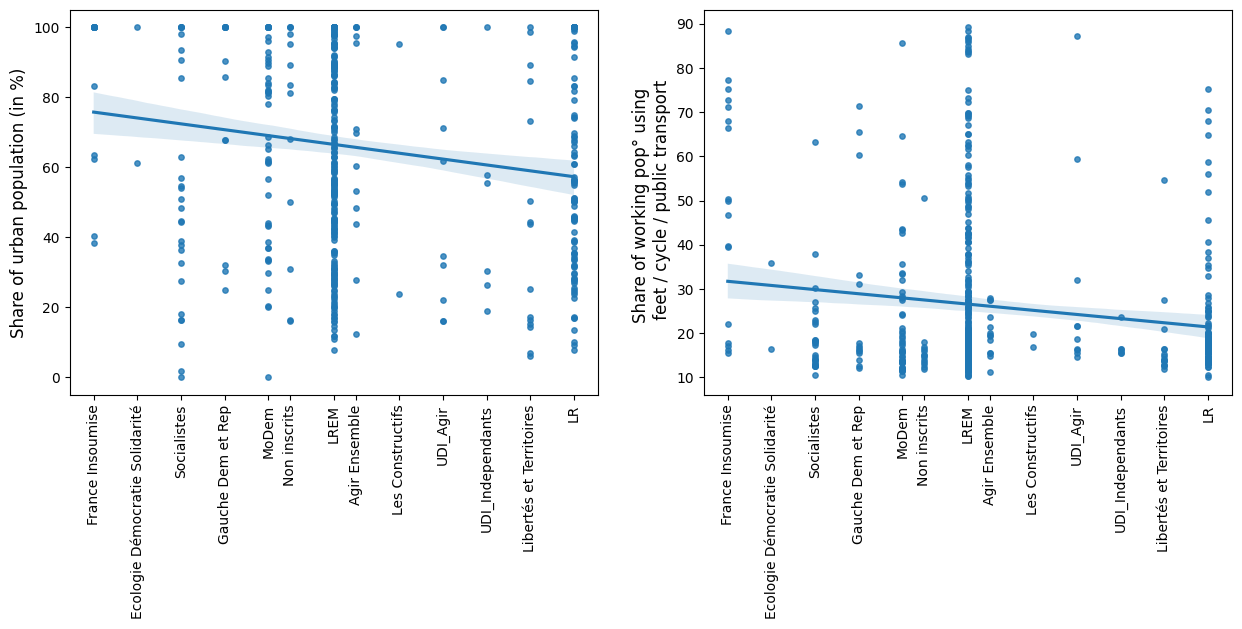

In [33]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.regplot(data=df_to_plot, x='Left_right', y='pop_urb',scatter_kws={'s':15})
plt.xticks(list(Left_right_dict.values()),list(Left_right_dict.keys()), rotation = 90)
#slope, intercept = np.polyfit(df_to_plot['Left_right'], df_to_plot['pop_urb'], 1)
#eq_text = f'y = {slope:.2f}x + {intercept:.2f}'
#plt.annotate(eq_text, xy=(0.01, 0.1), xycoords='axes fraction', fontsize=12, ha='left', va='top')
plt.xlabel('')
plt.ylabel('Share of urban population (in %)',fontdict = {'fontsize' : 12})

plt.subplot(1,2,2)
sns.regplot(data=df_to_plot, x='Left_right', y='pied/velo/transport en commun',scatter_kws={'s':15})
plt.xticks(list(Left_right_dict.values()),list(Left_right_dict.keys()), rotation = 90)
#slope, intercept = np.polyfit(df_to_plot['Left_right'], df_to_plot['pied/velo/transport en commun'], 1)
#eq_text = f'y = {slope:.2f}x + {intercept:.2f}'
#plt.annotate(eq_text, xy=(0.01, 0.1), xycoords='axes fraction', fontsize=12, ha='left', va='top')
plt.xlabel('')
plt.ylabel('Share of working pop° using \n feet / cycle / public transport',fontdict = {'fontsize' : 12})

plt.savefig(os.path.join(path,'Figures/Population urbaine et mode de transports.pdf'),bbox_inches='tight')
plt.show()

## Votes that interest us (linked to carbon tax)

In [34]:
df_scrutins.sort_values('date_scrutin', axis = 0, inplace = True)

### Projet loi de Finances pour 2018 :
    date début d'examen : 10 octobre 2017

In [35]:
df_scrutins['article 9'] = df_scrutins['titre'].apply(lambda x : 'article 9 du projet de loi de finances pour 2018' in x)
df_scrutins_article9 = df_scrutins[df_scrutins['article 9'] == True]

In [36]:
df_scrutins_article9

,Unnamed: 0,idScrutin,date_scrutin,code_type_vote,titre,demandeur,organe_ref,votants,pour,contre,non_votants,non_votants_volontaires,abstention,resultat,article 9
527,527,527,2017-10-21,SPO,l'amendement n° 409 de Mme Louwagie à l'articl...,"Président du groupe ""Les Républicains""",PO717460,69,14,53,2,0,2,rejeté,True


In [37]:
df_scrutins_article9['titre'][527]

"l'amendement n° 409 de Mme Louwagie à l'article 9 du projet de loi de finances pour 2018 (première lecture)."

In [38]:
scrutin_article_9_PLF18 = 527

liste_scrutins = []
liste_scrutins += [scrutin_article_9_PLF18]

### Projet loi de Finances pour 2019 

In [39]:
df_scrutins['finances 19'] = df_scrutins['titre'].apply(lambda x : 'projet de loi de finances pour 2019' in x)
df_finances_19 = df_scrutins[df_scrutins['finances 19'] == True]

In [40]:
pd.set_option('display.max_colwidth', None)
df_finances_19['titre']

4255                                                                                          la motion de renvoi en commission, déposée par M. André Chassaigne, du projet de loi de finances pour 2019 (première lecture).
3202                                                                                                           l'amendement n° 570 de M. Le Fur après l'article 2 du projet de loi de finances pour 2019 (première lecture).
618                                                                                l'amendement n° 613 de M. Abad et l'amendement identique suivant à l'article 2 du projet de loi de finances pour 2019 (première lecture).
691                                                                                                         l'amendement n° 1328 de M. Dufrègne après l'article 2 du projet de loi de finances pour 2019 (première lecture).
3672                                                                                                       l'amendem

**Article 18 tercidies** that froze the increase of carbon taxation (the first claim fo Yellow vests movement) has not been submitted to a public vote so **is not recorded**

### Loi climat et résilience : zones à faibles émissions

Article 27 extends the obligation to establish **low-emission mobility zones** in metropolitan areas with more than 150,000 inhabitants by the end of 2024.

In [41]:
df_scrutins['climat'] = df_scrutins['titre'].apply(lambda x : 'climatique' in x)
df_scrutins_climat = df_scrutins[df_scrutins['climat'] == True]

In [42]:
df_scrutins_climat['article 27'] = df_scrutins_climat['titre'].apply(lambda  x : 'article 27' in x)
df_climat_27 = df_scrutins_climat[df_scrutins_climat['article 27'] == True]

In [43]:
df_climat_27

,Unnamed: 0,idScrutin,date_scrutin,code_type_vote,titre,demandeur,organe_ref,votants,pour,contre,non_votants,non_votants_volontaires,abstention,resultat,article 9,finances 19,climat,article 27
2050,2050,2050,2021-04-10,SPO,l'amendement n° 3631 de M. Leseul à l'article 27 bis du projet de loi portant lutte contre le dérèglement climatique et renforcement de la résilience face à ses effets (première lecture).,"Présidente du groupe ""Socialistes et apparentés""",PO717460,91,10,79,2,0,2,rejeté,False,False,True,True
1591,1591,1591,2021-04-10,SPO,l'amendement n° 6015 de M. Zulesi après l'article 27 du projet de loi portant lutte contre le dérèglement climatique et renforcement de la résilience face à ses effets (première lecture).,"Président du groupe ""La République en Marche""",PO717460,95,93,0,2,0,2,adopté,False,False,True,True
542,542,542,2021-04-10,SPO,l'amendement n° 4085 de M. Potier à l'article 27 du projet de loi portant lutte contre le dérèglement climatique et renforcement de la résilience face à ses effets (première lecture).,"Présidente du groupe ""Socialistes et apparentés""",PO717460,91,11,72,2,0,8,rejeté,False,False,True,True
225,225,225,2021-04-10,SPO,l'amendement n° 7026 de M. Lambert après l'article 27 du projet de loi portant lutte contre le dérèglement climatique et renforcement de la résilience face à ses effets (première lecture).,"Président du groupe ""Libertés et Territoires""",PO717460,102,10,85,2,0,7,rejeté,False,False,True,True
936,936,936,2021-04-10,SPO,l'amendement n° 5385 de M. Favennec-Bécot à l'article 27 du projet de loi portant lutte contre le dérèglement climatique et renforcement de la résilience face à ses effets (première lecture).,"Président du groupe ""UDI et Indépendants""",PO717460,98,15,75,2,0,8,rejeté,False,False,True,True
4183,4183,4183,2021-04-10,SPO,l'amendement n° 7210 de M. Fugit à l'article 27 du projet de loi portant lutte contre le dérèglement climatique et renforcement de la résilience face à ses effets (première lecture).,"Président du groupe ""La République en Marche""",PO717460,92,86,2,2,0,4,adopté,False,False,True,True
858,858,858,2021-04-10,SPO,l'amendement n° 6010 de M. Zulesi après l'article 27 du projet de loi portant lutte contre le dérèglement climatique et renforcement de la résilience face à ses effets (première lecture).,"Président du groupe ""La République en Marche""",PO717460,98,96,0,2,0,2,adopté,False,False,True,True
138,138,138,2021-04-10,SPO,l'article 27 du projet de loi portant lutte contre le dérèglement climatique et renforcement de la résilience face à ses effets (première lecture).,"Président du groupe ""La République en Marche""\rPrésident du groupe ""Les Républicains""",PO717460,96,84,12,2,0,0,adopté,False,False,True,True
94,94,94,2021-04-10,SPO,l'amendement n° 3629 de M. Leseul à l'article 27 du projet de loi portant lutte contre le dérèglement climatique et renforcement de la résilience face à ses effets (première lecture).,"Présidente du groupe ""Socialistes et apparentés""",PO717460,93,20,66,2,0,7,rejeté,False,False,True,True
4146,4146,4146,2021-04-10,SPO,l'amendement n° 3433 de M. Lambert à l'article 27 du projet de loi portant lutte contre le dérèglement climatique et renforcement de la résilience face à ses effets (première lecture).,"Président du groupe ""Libertés et Territoires""",PO717460,65,11,51,2,0,3,rejeté,False,False,True,True


Amendements : 2479, 5385, 6401, 4603, 5465, 5542, 1836 et 4877 are about Collection vehicles. 

In [44]:
scrutin_article_27_PLCR21 = 138

liste_scrutins += [scrutin_article_27_PLCR21]

In [45]:
liste_scrutins

[527, 138]

In [46]:
df_scrutins[df_scrutins['idScrutin'].isin(liste_scrutins) == True]

,Unnamed: 0,idScrutin,date_scrutin,code_type_vote,titre,demandeur,organe_ref,votants,pour,contre,non_votants,non_votants_volontaires,abstention,resultat,article 9,finances 19,climat
527,527,527,2017-10-21,SPO,l'amendement n° 409 de Mme Louwagie à l'article 9 du projet de loi de finances pour 2018 (première lecture).,"Président du groupe ""Les Républicains""",PO717460,69,14,53,2,0,2,rejeté,True,False,False
138,138,138,2021-04-10,SPO,l'article 27 du projet de loi portant lutte contre le dérèglement climatique et renforcement de la résilience face à ses effets (première lecture).,"Président du groupe ""La République en Marche""\rPrésident du groupe ""Les Républicains""",PO717460,96,84,12,2,0,0,adopté,False,False,True


In [47]:
df_reg = df_final[df_final['idScrutin'].isin(liste_scrutins) == True]

In [48]:
df_reg

,idScrutin,idVotant,NomGroupe,vote_0_1,group_position,Département,Numéro de circonscription,circo,Nom de la circonscription,pop_urb,...,modtrans_moto,modtrans_voit,modtrans_commun,urbain,non-urbain,median_voter_is_urban,moto/voiture,pied/velo/transport en commun,median_voter_isnot_car_driver,Numéro
11763,138,PA719616,Agir Ensemble,True,True,Hérault,7,34007,Hérault - 7e circonscription,69.7,...,3.2,76.7,4.5,69.7,30.3,True,79.9,20.1,False,7e circonscription
11764,138,PA720500,Agir Ensemble,True,True,Nord,9,59009,Nord - 9e circonscription,100.0,...,1.0,65.1,21.6,100.0,0.0,True,66.1,34.0,False,9e circonscription
11766,138,PA722030,Agir Ensemble,True,True,Paris,18,75018,Paris - 18e circonscription,100.0,...,5.8,6.8,67.5,100.0,0.0,True,12.6,87.3,True,18e circonscription
11768,138,PA719578,France Insoumise,False,False,Gironde,3,33003,Gironde - 3e circonscription,100.0,...,2.4,58.1,22.4,100.0,0.0,True,60.5,39.5,False,3e circonscription
11769,138,PA720286,France Insoumise,False,False,Meurthe-et-Moselle,6,54006,Meurthe-et-Moselle - 6e circonscription,62.3,...,0.7,83.2,7.2,62.3,37.7,True,83.9,16.1,False,6e circonscription
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48984,527,PA721234,MoDem,False,False,Val-de-Marne,4,94004,Val-de-Marne - 4e circonscription,100.0,...,2.8,54.5,35.2,100.0,0.0,True,57.3,42.6,False,4e circonscription
48985,527,PA721836,MoDem,False,False,Yvelines,2,78002,Yvelines - 2e circonscription,96.0,...,2.8,54.0,30.4,96.0,4.0,True,56.8,43.3,False,2e circonscription
48986,527,PA721924,MoDem,False,False,Yvelines,7,78007,Yvelines - 7e circonscription,100.0,...,1.5,54.9,35.6,100.0,0.0,True,56.4,43.5,False,7e circonscription
48987,527,PA609332,Socialistes,True,True,Seine-et-Marne,11,77011,Seine-et-Marne - 11e circonscription,98.0,...,0.7,61.5,31.1,98.0,2.0,True,62.2,37.8,False,11e circonscription


In [49]:
# Truthvalue of both votes is different, we have to make it consistent

# Scrutin 138 is in favor of Low Emissions Zone
df_reg.loc[df_reg['idScrutin'] == 138,['vote_0_1','group_position']] = df_reg.loc[df_reg['idScrutin'] == 138,
                                                                                   ['vote_0_1','group_position']].astype(int)
# Scrutin 527 is agaisnt an steeper increase of carbon tax
df_reg.loc[df_reg['idScrutin'] == 527,['vote_0_1','group_position']] = 1 - df_reg.loc[df_reg['idScrutin'] == 527,
                                                                                       ['vote_0_1','group_position']]

In [50]:
df_reg[['median_voter_is_urban','median_voter_isnot_car_driver']] = df_reg[['median_voter_is_urban',
                                                                         'median_voter_isnot_car_driver']].astype(int)

In [51]:
df_reg_final = df_reg[['vote_0_1','group_position','urbain','median_voter_is_urban','moto/voiture','median_voter_isnot_car_driver']]

In [52]:
df_reg_final.to_csv(os.path.join(data_path,'database_for_regression.csv'))